# Image classification

**DESCRIPTION**

Facial recognition is a biometric alternative that measures unique characteristics of a human face. Applications available today include flight check in, tagging friends and family members in photos, and “tailored” advertising. You are a computer vision engineer who needs to develop a
face recognition programme with deep convolutional neural networks.

**Objective:** Use a deep convolutional neural network to perform facial recognition using Keras.

**Dataset Details:**

ORL face database composed of 400 images of size 112 x 92. There are 40 people, 10 images per person. The images were taken at different times, lighting and facial expressions. The faces are in an upright position in frontal view, with a slight left-right rotation.

**Link to the Dataset:** https://www.dropbox.com/s/i7uzp5yxk7wruva/ORL_faces.npz?dl=0

**Prerequisites:**
Keras
Scikit Learn
Steps to be followed:
1. Input the required libraries
2. Load the dataset after loading the dataset, you have to normalize every image.
3. Split the dataset
4. Transform the images to equal sizes to feed in CNN
5. Build a CNN model that has 3 main layers:

i. Convolutional Layer
ii. Pooling Layer
iii. Fully Connected Layer

6. Train the model
7. Plot the result
8. Iterate the model until the accuracy is above 90%

## Setup


###Instal library

In [1]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 51.3 MB/s 


###Import necessary libraries:

In [2]:
import math
import numpy as np
from numpy.fft import fft2, ifft2
import pandas as pd
import os
import shutil
import pathlib
import PIL
import cv2
import progressbar

from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input, Model

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

###Functions

In [43]:
def pd_df_multi_class_confusion_matrix(pd_s_target, pd_s_predict):
  class_sample_ = pd_s_target.unique()
  cm = confusion_matrix(pd_s_target, pd_s_predict, labels=class_sample_)
  multi_columns = zip(['Predicted label']*(len(class_sample_)), class_sample_)
  multi_index = zip(['Actual label']*(len(class_sample_)), class_sample_)
  multi_columns = pd.MultiIndex.from_tuples(list(multi_columns))
  multi_index = pd.MultiIndex.from_tuples(list(multi_index))
  return pd.DataFrame(cm, columns=multi_columns, index=multi_index)

## Download and explore the dataset

###Data aquisition

In [4]:
#read train feature data
np_train_X = np.load('/content/trainX.npy')
#read train target data
np_train_y = np.load('/content/trainY.npy')
#read test feature data
np_test_X = np.load('/content/testX.npy')
#read test target data
np_test_y = np.load('/content/testY.npy')

In [5]:
np.unique(np_train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8)

In [6]:
np.unique(np_test_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8)

###Create path for data

In [7]:
def createDirectory(path):
  # checking if the directory demo_folder 
  # exist or not
  if not os.path.exists(path):
    # if the demo_folder directory is not present 
    # then create it
    os.makedirs(path)

In [8]:
#shutil.rmtree('/content/data')

In [9]:
#create directory of train data
path = '/content/data/train'
for i in np.unique(np_train_y):
  tmp_path = '{}/{}'.format(path, i)
  createDirectory(tmp_path)

In [10]:
#create directory of test data
path = '/content/data/test'
for i in np.unique(np_test_y):
  tmp_path = '{}/{}'.format(path, i)
  createDirectory(tmp_path)

###Data augmentation

####Function

In [11]:
#disc ones function to distorsionate image
def disc(size):
  r = int(size / 2)
  y,x = np.ogrid[-r: r+1, -r: r+1]
  mask = x**2+y**2 > r**2
  np_disc = np.ones((size, size))
  np_disc[mask] = 0
  np_disc = np_disc / (np_disc.sum() + 1)
  return np_disc

#disc random function to distorsionate image
def disc_rand(size):
  if (size == 1):
    np_disc = np.array([np.random.uniform(low=0.01, high=0.091, size=1)])
  else:
    r = int(size / 2)
    y,x = np.ogrid[-r: r+1, -r: r+1]
    mask = x**2+y**2 > r**2
    np_disc = np.random.uniform(low=0.01, high=0.091, size=(size, size))
    np_neg_idx_x, np_neg_idx_y  = np.random.randint(low=0, high=(size-1), size=2).flatten()
    np_disc[np_neg_idx_x, np_neg_idx_y] *= -1.
    np_disc[mask] = 0
    np_disc = np_disc / (np_disc.sum() + 1)
  return np_disc

In [12]:
#noise function
def noise(np_array):
  size_ = np.prod(np_array.shape)
  tmp_data = np_array.reshape(size_)
  #get noise
  np_noise = np.random.randint(low=-10, high=10, size=size_)
  #add noise
  tmp_data = np.array(tmp_data + np_noise)
  #standardization
  np_idx_pos = np.argwhere(tmp_data > 255)
  tmp_data[np_idx_pos] = 255
  
  np_idx_neg = np.argwhere(tmp_data < 0)
  tmp_data[np_idx_neg] = 0

  tmp_data = np.array(tmp_data, dtype=np.uint8).reshape(np_array.shape)
  return tmp_data

#rotation function
def rotationAndNoise(np_data):
  theta = np.random.uniform(low=-180., high=180., size=1)[0]
  hight, width, channel = np_data.shape
  M = cv2.getRotationMatrix2D((width / 2, hight / 2), theta, 1)
  tmp_data = cv2.warpAffine(np_data, M, (width, hight))
  tmp_data = noise(tmp_data)
  return tmp_data

#randomly flips numpy array
def flipArray(np_array):
  flip_arr = [1, -1, 1, -1, -1, 1, 1]
  np.random.shuffle(flip_arr)
  np_array = np_array[::flip_arr[0],::flip_arr[1]]
  return np_array

#filtre wiener
def Wiener(np_data):
  #get random size of kernel
  size_kernel = [1, 3, 5]
  np.random.shuffle(size_kernel)
  size_kernel = size_kernel[0]
  lst_wiener.append({'size_kernel':size_kernel})
  #get random distorsion function
  isDisc = ((np.random.randint(low=-10, high=10, size=1)[0]) > 0)
  lst_wiener.append({'isDisc':isDisc})
  if (isDisc):
    tmp_kernel = disc(size_kernel)
    Lambda = np.random.uniform(low=0.21, high=0.9, size=1)[0]
  else:
    tmp_kernel = disc_rand(size_kernel)
    Lambda = np.random.uniform(low=0.25, high=0.5, size=1)[0]
  lst_wiener.append({'tmp_kernel':tmp_kernel})
  lst_wiener.append({'Lambda':Lambda})

  hight, width, channel = np_data.shape

  pad_hight, pad_width = hight - size_kernel, width - size_kernel
  tmp_kernel = np.pad(tmp_kernel,((0, pad_hight), (0, pad_width)))
  tmp_fft2_kernel = fft2(tmp_kernel)
  w = np.conj(tmp_fft2_kernel) / (np.conj(tmp_fft2_kernel) * tmp_fft2_kernel + Lambda)
  out = np.real(ifft2(w * fft2(np_data[:,:,0])))

  return out


####Augmentation

In [13]:
#create a list of augmented function
lst_augmentation_func = [noise, rotationAndNoise, Wiener]


def data_augmentation(path, np_array_X, np_array_y, nbr_gen_for_sample):
  widgets = [' [',
         progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
         '] ',
           progressbar.Bar('*'),' (',
           progressbar.ETA(), ') ',
          ]
  max_value_bar = np_array_X.shape[0]*(nbr_gen_for_sample + 1)
  bar = progressbar.ProgressBar(
                      max_value=max_value_bar, 
                      widgets=widgets).start()
  shape_ = np_array_X[0].shape
  #index filename for image name
  idx_filename = 0
  #save row data
  for np_feature, np_target in zip(np_array_X, np_array_y):
    filename = '{}/{}/{}.png'.format(path, np_target, idx_filename)
    lst_filename.append(filename)
    cv2.imwrite(filename, np_feature.astype(np.uint8))
    #updata name of next filename
    idx_filename+=1
    bar.update(idx_filename)

  #save generated data
  for i in range(nbr_gen_for_sample):
    for np_feature, np_target in zip(np_array_X, np_array_y):
      #get random index to generate image
      idx_img_gen = np.random.randint(low=0, high=3, size=1)[0]
      lst_idx_gen.append(idx_img_gen)
      tmp_np_gen_arr = lst_augmentation_func[idx_img_gen](np_feature)
      tmp_np_gen_arr = flipArray(tmp_np_gen_arr).reshape(shape_)
      #save image
      filename = '{}/{}/{}.png'.format(path, np_target, idx_filename)
      lst_filename.append(filename)
      cv2.imwrite(filename, tmp_np_gen_arr.astype(np.uint8))
      #updata name of next filename
      idx_filename+=1
      bar.update(idx_filename)



####Generate data

In [14]:
#generate train data
lst_idx_gen = []
lst_wiener = []
lst_filename = []
nbr_gen_for_sample = 100
path = '/content/data/train'
np_train_X = np_train_X.reshape(np_train_X.shape[0], 112, 92, 1)
#generate train data
data_augmentation(path, np_train_X, np_train_y, nbr_gen_for_sample)

 [elapsed time: 0:00:35] |********************************* | (ETA:   0:00:00) 

In [15]:
#generate test data
lst_idx_gen = []
lst_wiener = []
lst_filename = []
nbr_gen_for_sample = 40
path = '/content/data/test'
np_test_X = np_test_X.reshape(np_test_X.shape[0], 112, 92, 1)
#generate test data
data_augmentation(path, np_test_X, np_test_y, nbr_gen_for_sample)

 [elapsed time: 0:00:07] |********************************* | (ETA:   0:00:00) 

###Upload train and test data

In [16]:
import pathlib

In [17]:
train_dir = '/content/data/train'
train_dir = pathlib.Path(train_dir)

In [18]:
test_dir = '/content/data/test'
test_dir = pathlib.Path(test_dir)

In [19]:
image_count = len(list(train_dir.glob('*/*.png')))
print('Number of train image {}'.format(image_count))

Number of train image 24240


In [20]:
image_count = len(list(test_dir.glob('*/*.png')))
print('Number of test image {}'.format(image_count))

Number of test image 6560


## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take us from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

### Create a dataset

Define some parameters for the loader:

In [21]:
batch_size = 10
img_height = 112
img_width = 92
img_channel = 1

Split data in test and validation

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=12534,
  batch_size=batch_size,
  label_mode='categorical',
  color_mode='grayscale')

Found 24240 files belonging to 20 classes.


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  shuffle=True,
  seed=42,
  batch_size=batch_size,
  label_mode='categorical',
  color_mode='grayscale')

Found 6560 files belonging to 20 classes.


We can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [24]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


## Visualize the data

Here are the first nine images from the training dataset:

10


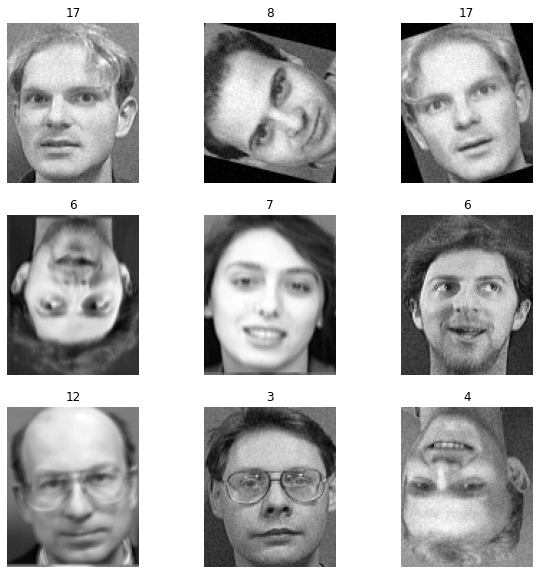

In [25]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].numpy().astype("uint8").reshape(img_height, img_width)
    #print(labels[i])
    plt.imshow(img, cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

## Configure the dataset for performance

Make sure to use buffered prefetching, so we can yield data from disk without having I/O become blocking. These are two important methods we need to use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model. If our dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## A basic Keras model

### Create the model

In [27]:
num_classes = len(class_names)

input = Input(
              shape=(img_height, img_width, img_channel),
              name='Input',
              dtype=np.uint8
              )
#We will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
x = layers.Rescaling(1./255, 
                     input_shape=(img_height, img_width, img_channel))(input)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid')(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(num_classes * 2, activation='relu')(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(num_classes, activation='softmax')(x)


In [29]:
#create model
model = Model(input, output)

### Compile the model

We will, use the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.MeanSquaredError` loss function.

In [30]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 112, 92, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 112, 92, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 112, 92, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 46, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 46, 128)       147584    
                                                                 
 batch_normalization (BatchN  (None, 56, 46, 128)      512       
 ormalization)                                               

### Train and visualize the model results

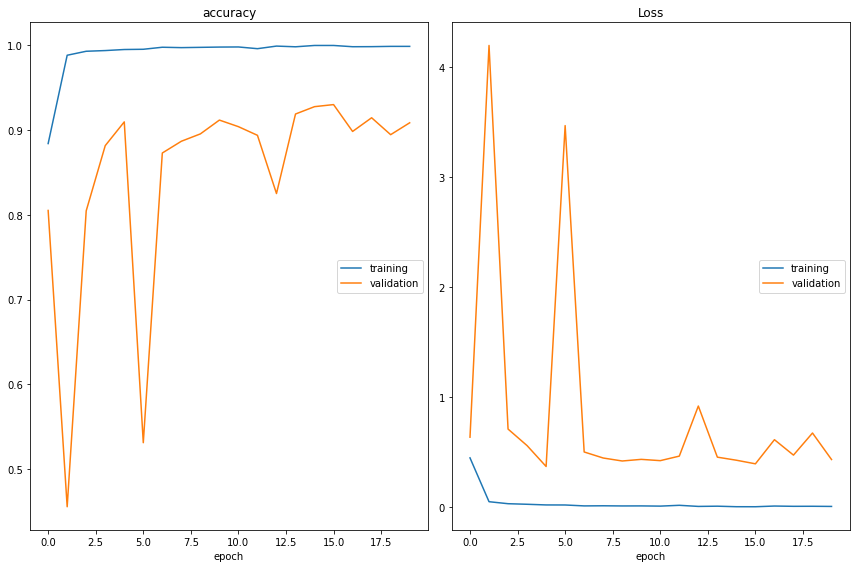

accuracy
	training         	 (min:    0.884, max:    1.000, cur:    0.999)
	validation       	 (min:    0.455, max:    0.930, cur:    0.909)
Loss
	training         	 (min:    0.000, max:    0.445, cur:    0.003)
	validation       	 (min:    0.366, max:    4.197, cur:    0.430)
2424/2424 [==============================] - 42s 17ms/step - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.4297 - val_accuracy: 0.9087


In [32]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[PlotLossesKerasTF()]
)

## Predict on test data

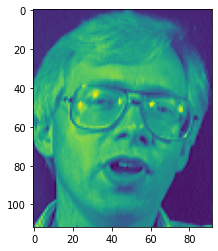

1/1 [==============================] - 0s 263ms/step
This image most likely belongs to person 1 with a 100.00 percent confidence.


In [33]:
test_path = '/content/data/test/1/10.png'
img = tf.keras.utils.load_img(
    test_path, 
    target_size=(img_height, img_width, img_channel),
    color_mode='grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

plt.imshow(np.array(img_array[0]).reshape(img_height, img_width))
plt.show()
score = model.predict(img_array)
print(
    "This image most likely belongs to person {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [34]:
#find name of all images ending with jpg
root = '/content/data/test'
lst_all_filename = []
for path, subdirs, files in os.walk(root):
  if (files != [] and files != None):
    idx_img = np.random.randint(low=0, high=len(files), size=1)[0]
    name = files[idx_img]
    lst_all_filename.append(os.path.join(path, name))

lst_all_filename.sort()

1/1 [==============================] - 0s 40ms/step


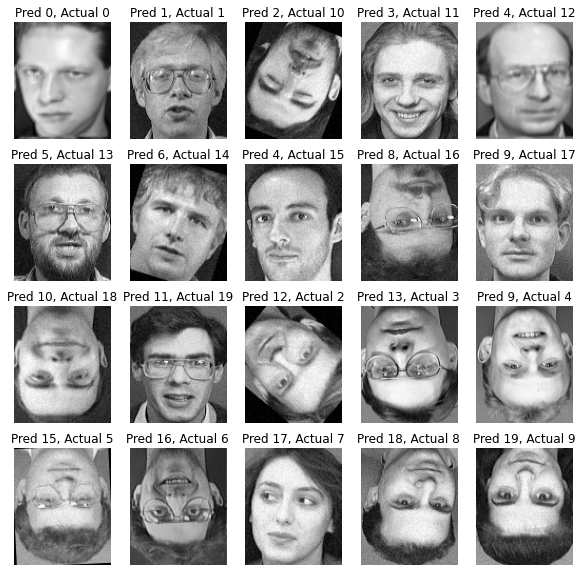

In [35]:
plt.figure(figsize=(10, 10))
for i, filename in zip(range(20), lst_all_filename):
  ax = plt.subplot(4, 5, i + 1)
  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  plt.imshow(img, cmap='gray')
  img = img.reshape(img_height, img_width, img_channel)
  label = model.predict(np.array([img]))
  tmp_title = 'Pred {}, Actual {}'.format(np.argmax(label), filename.split('/')[4])
  plt.title(tmp_title)
  plt.axis("off")

In [59]:
#find name of all images ending with jpg
root = '/content/data/test'
d_clas_filename = {}
for path, subdirs, files in os.walk(root):
  if (files != [] and files != None):
    d_clas_filename[int(path.split('/')[4])] = (path, files)

In [60]:
#check finale test evaluation metrics

lst_prediction = []
lst_actual = []
keys = list(d_clas_filename.keys())
for key in keys:
  path = d_clas_filename[key][0]
  for filename in d_clas_filename[key][1]:
    img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img_height, img_width, img_channel)
    label = model.predict(np.array([img]))
    lst_actual.append(key)
    lst_prediction.append(int(class_names[np.argmax(label)]))
  

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 19ms/step


In [61]:
#Evaluation Metrics test data
print(metrics.classification_report(lst_actual, lst_prediction))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       328
           1       0.94      0.97      0.95       328
           2       0.89      0.98      0.93       328
           3       0.88      0.97      0.93       328
           4       0.84      0.76      0.80       328
           5       0.99      0.98      0.99       328
           6       0.99      0.99      0.99       328
           7       0.79      0.98      0.87       328
           8       0.99      0.95      0.97       328
           9       0.89      0.72      0.80       328
          10       0.92      0.98      0.95       328
          11       0.99      0.96      0.98       328
          12       0.85      0.97      0.90       328
          13       1.00      0.91      0.96       328
          14       0.87      0.94      0.90       328
          15       0.98      0.72      0.83       328
          16       0.97      0.87      0.92       328
          17       0.80    

In [62]:
pd_df_multi_class_confusion_matrix(pd.Series(lst_actual), pd.Series(lst_prediction))

Predicted label                                               \
                             16   9    2    8    11   0    4    12   5    17   
Actual label 16             284    0    1    0    0   14    8    0    0    0   
             9                7  237   14    0    0    0    0    0    0    0   
             2                0    1  320    0    0    0    1    0    0    0   
             8                0    0    2  311    0    0    3    0    0    0   
             11               0    0    6    0  316    0    1    0    0    1   
             0                0    0    0    0    0  297   14   11    0    0   
             4                0    0    1    2    0    1  250    0    0   67   
             12               0    0    2    0    0    0    3  318    0    0   
             5                0    0    0    0    0    0    6    0  322    0   
             17               0    0    0    0    0    0    6    0    0  320   
             13               0    1    0    0    0    0    0    0    0    0   
             18               0    0    0    0    0    2    0    0    0    0   
             3                1    0    5    1    0    0    2    0    0    0   
             6                0    0    0    0    0    0    0    0    0    0   
             10               0    0    0    0    0    1    0    0    0    0   
             1                0    0    0    0    0    0    0    1    0    0   
             15               0    1    2    0    0   20    0   44    1    9   
             19               0   25    7    0    4    0    0    0    0    1   
             14               0    0    0    0    0    0    3    1    1    0   
             7                0    0    1    0    0    2    2    0    0    0   

                                                                   
                  13   18   3    6    10   1    15   19   14   7   
Actual label 16    0    0    8    0    0    0    0    0   11    2  
             9     0    0   16    0   25    0    0    0    3   26  
             2     0    0    2    0    2    0    0    0    0    2  
             8     0    0   12    0    0    0    0    0    0    0  
             11    0    0    0    0    0    0    0    0    4    0  
             0     0    5    0    0    0    0    1    0    0    0  
             4     0    0    0    0    0    0    0    0    7    0  
             12    0    1    0    0    0    2    0    0    2    0  
             5     0    0    0    0    0    0    0    0    0    0  
             17    0    0    1    0    0    1    0    0    0    0  
             13  300    0    1    0    0    3    0   22    1    0  
             18    0  254    0    0    0    2    1    1   11   57  
             3     0    0  319    0    0    0    0    0    0    0  
             6     0    0    0  324    0    0    0    4    0    0  
             10    0    0    0    0  322    0    1    4    0    0  
             1     0    1    0    0    0  318    0    0    8    0  
             15    0    2    2    0    0   12  235    0    0    0  
             19    0    0    0    4    1    0    0  286    0    0  
             14    0    2    0    0    0    1    0   13  307    0  
             7     0    1    0    0    0    0    1    0    0  321

1055930/1055930 [==============================] - 1s 1us/step


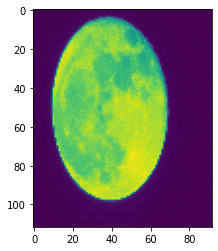

1/1 [==============================] - 0s 16ms/step
This image most likely belongs to person 7 with a 99.65 percent confidence.


In [63]:
moon_url = "https://tammyscowdogs.files.wordpress.com/2013/11/full-moon-mon-nov-19-2013-012.jpg"
test_path = tf.keras.utils.get_file('1', origin=moon_url)

#test_path = '/content/data/test/0/0.png'
img = tf.keras.utils.load_img(
    test_path, 
    target_size=(img_height, img_width, img_channel),
    color_mode='grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

plt.imshow(np.array(img_array[0]).reshape(img_height, img_width))
plt.show()
score = model.predict(img_array)
print(
    "This image most likely belongs to person {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#Conclusion

Our model predict more that 90% of test data, but can detect only trained face, if we have other image can be predicted like a person!